<a href="https://colab.research.google.com/github/tumibytes/cis9650-project03/blob/main/term_project_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Job Listings

### Authors: Elise Tumibay, Dylan Lee, Creed Berges, Dianny Nunez
### Date : December 8th, 2025

## Executive Summary

The dataset used in this project consists of thousands of job postings collected from public sources and stored in a Google Cloud bucket. These postings span multiple global companies across finance, insurance, fintech, consulting, and technology. Each posting contains structured information such as job title, company name, location, and posted date, as well as additional metadata like skill requirements, responsibilities, departments, or industry tags.

Within the 171 JSON files included in this project, we can explore key insights such as the demand for specific skills, opportunities for different work arrangements, geographical demand, and other labor market patterns. Since the pandemic, a notable portion of job postings reflect hybrid work options, highlighting how work culture has shifted in the post-COVID era. We will use the matplotlib library to use the data for analysis.

Analyzing this dataset provides valuable insight, that help us understand current workforce trends, skill demands, and hiring patterns across industries worldwide.

## Table of Contents

1. Introduction
2. Problem Statement / Research Question
3. Data Description
4. Setup and Environment
5. Data Loading
6. Data Preparation
7. Model Planning
8. Model Building / Analysis
9. Discussion & Interpretation
10. Conclusion
11. References
12. Appendix

## Introduction

The global job market has undergone substantial transformation in recent years, particularly in the wake of the COVID-19 pandemic. As companies adjust to new expectations around workplace flexibility, skill requirements, and talent mobility, job postings offer valuable insight into evolving labor trends. Analyzing large-scale job listing datasets can reveal which industries are hiring, where job opportunities are concentrated, and what employers expect from applicants in terms of skills, work arrangements, and compensation.

Our goal is to extract meaningful insights about hiring trends, workplace expectations, and labor market patterns during a period of significant post-pandemic transition. Using Python, pandas, and visualization tools, we consolidated and transformed the raw data, then explored key questions around regional hiring activity, work arrangement preferences, salary patterns, and skill demand reflected in job titles.

This project focuses on extracting and analyzing job postings stored across 171 JSON files provided for CIS9650 Project 03. Using these files, we aim to understand patterns across thousands of postings, including the types of roles being offered, common job structures, geographic hiring distribution, and the prevalence of hybrid or remote positions in a post-pandemic world. Through exploratory data analysis and visualization, we uncover high-level trends and opportunities for deeper future research.

## Problem Statement / Research Question

Research Question:  What patterns and trends can be observed in global job postings across industries in the post-pandemic era?

Problem Statement: New labor market patterns have emerged as a result of the fast evolution of work in a post-pandemic society. Global job postings can provide clues about labor market changes, workforce demands, work arrangements, and hiring trends in the post-pandemic period.




## Data Description
  The data in Project 03 consists of 171 json files. Each page of a json file in this project includes 100 job listings. Each file contains a set of job listings with a title, company, description, summary, salary, work arrangement, and other information relevant to job applicants.

## Setup and Environment

In [224]:
!pip install google-cloud-storage

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import plotly.express as px
import json
import os
from google.cloud import storage
from io import BytesIO

## Data Loading

### Functions

In [226]:
from google.cloud import storage

def list_public_bucket(bucket_name, course, project):
    prefix = f"{course}/Project {project}/"

    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name)
    blobs = client.list_blobs(bucket, prefix=prefix)
    print(f"Listing files in public bucket '{bucket_name}' under '{prefix}':")
    filenames = []
    for blob in blobs:
        print(blob.name)
        filenames.append(blob.name)

    return filenames

In [227]:
from google.cloud import storage
import pandas as pd
from io import BytesIO
import os
import json

def gcs_file_to_dataframe(bucket_name: str, blob_path: str):

    # Anonymous client for public buckets
    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_path)

    # Download file content as bytes
    data = blob.download_as_bytes()

    # Detect file extension
    _, ext = os.path.splitext(blob_path.lower())

    if ext == ".csv":
        df = pd.read_csv(BytesIO(data))

    elif ext in [".xls", ".xlsx"]:
        df = pd.read_excel(BytesIO(data))

    elif ext == ".parquet":
        df = pd.read_parquet(BytesIO(data))

    elif ext == ".json":
        # Convert bytes → Python object
        text = data.decode("utf-8")
        json_obj = json.loads(text)

        # If JSON is a list → NORMAL DataFrame
        if isinstance(json_obj, list):
            df = pd.DataFrame(json_obj)

        # If JSON is a dict → flatten into rows
        elif isinstance(json_obj, dict):
            df = pd.json_normalize(json_obj)

        else:
            raise ValueError("Unsupported JSON structure")

    else:
        raise ValueError(f"Unsupported file type: {ext}")

    return df

In [228]:
# Example
BUCKET_NAME = "msba-online-data"
PROJECT_NUMBER = "03"
COURSE = "CIS9650"
job_listings = list_public_bucket(BUCKET_NAME,COURSE,PROJECT_NUMBER)

Listing files in public bucket 'msba-online-data' under 'CIS9650/Project 03/':
CIS9650/Project 03/
CIS9650/Project 03/page_1.json
CIS9650/Project 03/page_10.json
CIS9650/Project 03/page_100.json
CIS9650/Project 03/page_101.json
CIS9650/Project 03/page_102.json
CIS9650/Project 03/page_103.json
CIS9650/Project 03/page_104.json
CIS9650/Project 03/page_105.json
CIS9650/Project 03/page_106.json
CIS9650/Project 03/page_107.json
CIS9650/Project 03/page_108.json
CIS9650/Project 03/page_109.json
CIS9650/Project 03/page_11.json
CIS9650/Project 03/page_110.json
CIS9650/Project 03/page_111.json
CIS9650/Project 03/page_112.json
CIS9650/Project 03/page_113.json
CIS9650/Project 03/page_114.json
CIS9650/Project 03/page_115.json
CIS9650/Project 03/page_116.json
CIS9650/Project 03/page_117.json
CIS9650/Project 03/page_118.json
CIS9650/Project 03/page_119.json
CIS9650/Project 03/page_12.json
CIS9650/Project 03/page_120.json
CIS9650/Project 03/page_121.json
CIS9650/Project 03/page_122.json
CIS9650/Project

In [229]:
appended_df = []

# for each file, add df to list
for element in job_listings[1:]:
    df = gcs_file_to_dataframe(BUCKET_NAME,  element)
    appended_df.append(df)
    # print(df.head())

In [230]:
df = pd.concat(appended_df, ignore_index=True)
# concat list to df

df_expanded = df.explode("data", ignore_index=True)

# 2. Convert the dict into columns
detail_cols = df_expanded["data"].apply(pd.Series)

# 3. Merge back and drop the dict column
df_flat = pd.concat([df_expanded.drop(columns=["data"]), detail_cols], axis=1)

df_flat

,meta.currentPage,meta.pageSize,meta.pageCount,meta.totalResults,meta.includeRemote,meta.sortBy,meta.facetQueryResults,meta.searchedLocation.countryCode2,meta.searchedLocation.radiusUnit,meta.searchedLocation.radius,...,locationId,cityId,countryId,language,minSalary,maxSalary,salaryCurrency,jobPaymentType,fullCompanyName,workArrangementType
0,1,100,343,34212,False,UNSORTED,[],US,km,100,...,4843564,4843564,6252001,EN,0,0,USD,PAID,Axa Investment Managers Paris,NaN
1,1,100,343,34212,False,UNSORTED,[],US,km,100,...,5128581,5128581,6252001,EN,83000,137000,USD,PAID,Deutsche Bank US,Hybrid
2,1,100,343,34212,False,UNSORTED,[],US,km,100,...,4459467,4459467,6252001,EN,100000,142250,USD,PAID,Deutsche Bank US,Hybrid
3,1,100,343,34212,False,UNSORTED,[],US,km,100,...,5045360,5045360,6252001,EN,84000,127000,USD,PAID,QBE Insurance (Europe) Limited,Remote
4,1,100,343,34212,False,UNSORTED,[],US,km,100,...,5275020,5275020,6252001,EN,100000,150000,USD,PAID,QBE Insurance (Europe) Limited,Remote
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17095,99,100,343,34219,False,UNSORTED,[],US,km,100,...,5262838,5262838,6252001,EN,0,0,USD,UNPAID,RADANCY - Fidelity Investments,NaN
17096,99,100,343,34219,False,UNSORTED,[],US,km,100,...,5391959,5391959,6252001,EN,0,0,USD,UNPAID,RADANCY - Fidelity Investments,NaN
17097,99,100,343,34219,False,UNSORTED,[],US,km,100,...,5746545,5746545,6252001,EN,0,0,USD,UNPAID,RADANCY - Fidelity Investments,NaN
17098,99,100,343,34219,False,UNSORTED,[],US,km,100,...,4984247,4984247,6252001,EN,0,0,USD,UNPAID,RADANCY - Fidelity Investments,NaN


## Data Preparation

In [231]:
print(df_flat.columns) # print columns of data frame to see what data we can use for visualization



Index(['meta.currentPage', 'meta.pageSize', 'meta.pageCount',
       'meta.totalResults', 'meta.includeRemote', 'meta.sortBy',
       'meta.facetQueryResults', 'meta.searchedLocation.countryCode2',
       'meta.searchedLocation.radiusUnit', 'meta.searchedLocation.radius',
       'meta.selectedFilters', 'meta.searchId', 'meta.totalJobCount',
       'meta.topCompanies', '_links.self.href', '_links.next.href',
       '_links.previous.href', '_links.last.href', '_links.first.href', 'id',
       'detailsPageUrl', 'title', 'jobLocation', 'postedDate', 'salary',
       'clientBrandId', 'clientBrandName', 'companyName', 'employmentType',
       'expirationDate', 'expirationDateType', 'isExternalApplication',
       'summary', 'description', 'isHighlighted', 'jobId', 'score',
       'companyLogoUrl', 'jobAdvertLogoUrl', 'positionType', 'sectors',
       'locationId', 'cityId', 'countryId', 'language', 'minSalary',
       'maxSalary', 'salaryCurrency', 'jobPaymentType', 'fullCompanyName',
      

In [232]:
# create lists of unique values for each column
title = df_flat["title"].unique()

# job location is a dictionary, we cannot get "unique" values here
# use apply method to get the unique values for each key
displayName = df_flat["jobLocation"].apply(lambda x: x.get("displayName")).unique()
city = df_flat["jobLocation"].apply(lambda x: x.get("city")).unique()
state = df_flat["jobLocation"].apply(lambda x: x.get("state")).unique()
country = df_flat["jobLocation"].apply(lambda x: x.get("country")).unique()
region = df_flat["jobLocation"].apply(lambda x: x.get("region")).unique()
# add columns to df for these keys
df_flat["displayName"] = df_flat["jobLocation"].apply(lambda x: x.get("displayName"))
df_flat["city"] = df_flat["jobLocation"].apply(lambda x: x.get("city"))
df_flat["state"] = df_flat["jobLocation"].apply(lambda x: x.get("state"))
df_flat["country"] = df_flat["jobLocation"].apply(lambda x: x.get("country"))
df_flat["region"] = df_flat["jobLocation"].apply(lambda x: x.get("region"))

In [233]:
# continue creating lists for unique values in each column
postedDate = df_flat["postedDate"].unique()
salary = df_flat["salary"].unique()
clientBrandId = df_flat["clientBrandId"].unique()
clientBrandName = df_flat["clientBrandName"].unique()
companyName = df_flat["companyName"].unique()
employmentType = df_flat["employmentType"].unique()
expirationDate = df_flat["expirationDate"].unique()
summary = df_flat["summary"].unique()
description = df_flat["description"].unique()
jobId = df_flat["jobId"].unique()
score = df_flat["score"].unique()
companyLogoUrl = df_flat["companyLogoUrl"].unique()
positionType = df_flat["positionType"].unique()


locationId = df_flat["locationId"].unique()
cityId = df_flat["cityId"].unique()
countryId = df_flat["countryId"].unique()
language = df_flat["language"].unique()
minSalary = df_flat["minSalary"].unique()
maxSalary = df_flat["maxSalary"].unique()
salaryCurrency = df_flat["salaryCurrency"].unique()
jobPaymentType = df_flat["jobPaymentType"].unique()
fullCompanyName = df_flat["fullCompanyName"].unique()
workArrangementType = df_flat["workArrangementType"].unique()
# get rid of nan value in unique list
workArrangementType = workArrangementType[pd.notna(workArrangementType)]
# print(workArrangementType) # debugging



In [234]:
# handle sectors differently
# sectors are lists in json file
sectors = []
for sector_list in df_flat["sectors"]:
    if isinstance(sector_list, list):
        for sector in sector_list:
            sectors.append(sector)
    elif isinstance(sector_list, str): # handle instance where only one sector is listed
        sector.append(sector)
sectors = set(sectors) # convert list of sectors to set for unique values

## Model Planning

From the unique values in the columns of our dataframe, we will utilize the matplotlib library to produce a variety of charts. These charts will provide us with further insight regarding our research question and problem statement. Finding the value counts for specific metrics will allow us to visualize the data and detect trends.

## Model building / Analysis

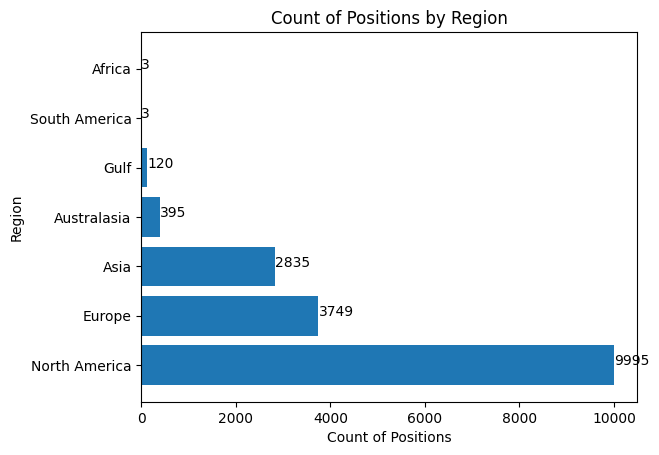

In [235]:
# plot the count of positions by region
fig, ax = plt.subplots()

region_count = df_flat["region"].value_counts()
bar_labels = region_count.index.tolist()
count = region_count.values.tolist()

ax.barh(bar_labels, count)
ax.set_ylabel("Region")
ax.set_xlabel("Count of Positions")
ax.set_title("Count of Positions by Region")

# add values to bar chart for analysis
for index, value in enumerate(region_count):
    plt.text(value, index, str(value))

plt.show()

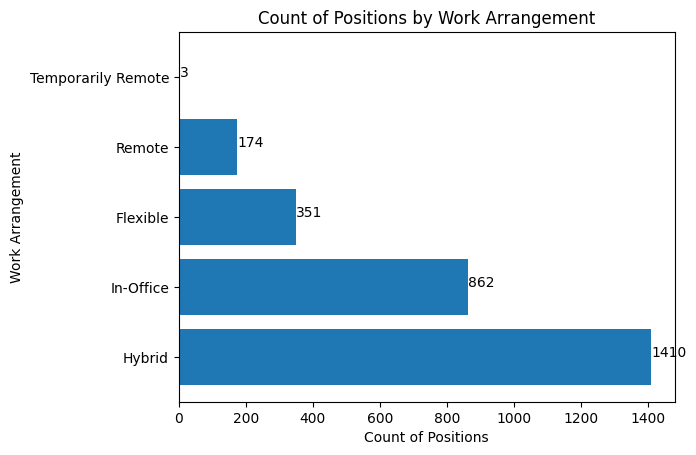

In [236]:
# plot the count of positions by work arrangement type
fig, ax = plt.subplots()

workArr_count = df_flat["workArrangementType"].value_counts()
bar_labels = workArr_count.index.tolist()
count = workArr_count.values.tolist()

ax.barh(bar_labels, count)
ax.set_ylabel("Work Arrangement")
ax.set_xlabel("Count of Positions")
ax.set_title("Count of Positions by Work Arrangement")

# add values to bar chart for analysis
for index, value in enumerate(workArr_count):
    plt.text(value, index, str(value))

plt.show()

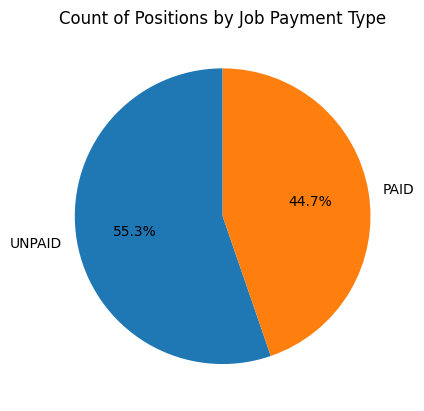

In [237]:
# pie chart the count of positions by job payment type

# Count how many jobs have each payment type
jobPay_count = df_flat["jobPaymentType"].value_counts()

# Make a pie chart
plt.pie(
    jobPay_count.values,     # The sizes of each slice
    labels=jobPay_count.index, # the name for each slice
    autopct="%1.1f%%",      # Show the percentage
    startangle=90 )        # start from the top

plt.title("Count of Positions by Job Payment Type") # Add a title
plt.show()

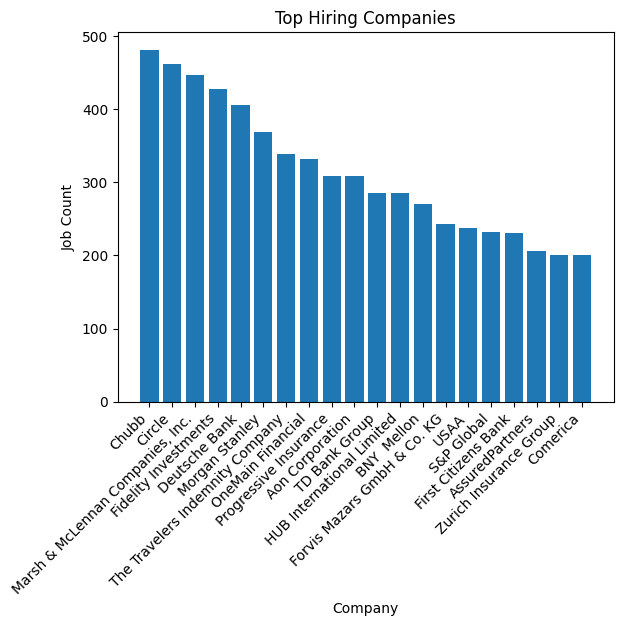

In [238]:
# plot the hiring companies

# Grab the 20 companies that posted the most jobs
company_count = df_flat["companyName"].value_counts().head(20)

# Draw a bar chart using matplotlib
plt.bar(company_count.index, company_count.values)
plt.xlabel("Company") # Name the x-axis
plt.ylabel("Job Count") # Name the y-axis
plt.title("Top Hiring Companies")  # Give the chart a title

plt.xticks(rotation=45, ha='right') # Rotate the company names so they're easier to read
plt.show()

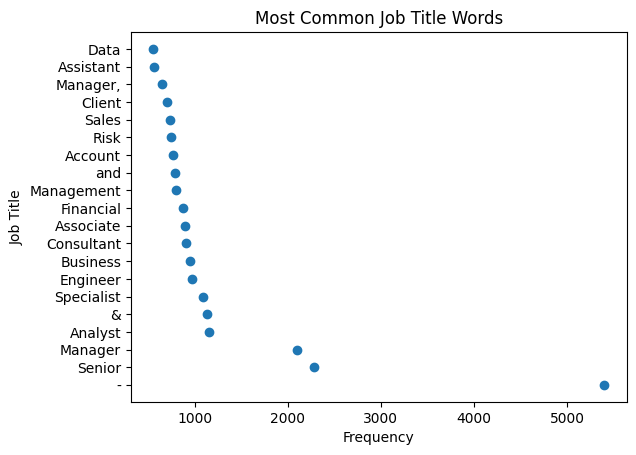

In [239]:
# plot the most common job title (Dot Plot)

word_count = {}    # Count how often each word appears in all job titles
for title in df_flat["title"]:
    if title == title:         # this simply ignores empty titles
        for word in title.split():
            word_count[word] = word_count.get(word, 0) + 1  # add to the word count

top = sorted(word_count.items(), key=lambda x: x[1], reverse=True)[:20]   # Get the top 20 most common

# Pull the words and counts into separate lists
labels = [word for word, count in top]
counts = [count for word, count in top]

# Plot the results as a dot plot
plt.scatter(counts, labels)
plt.xlabel("Frequency")
plt.ylabel("Job Title")
plt.title("Most Common Job Title Words")
plt.show()

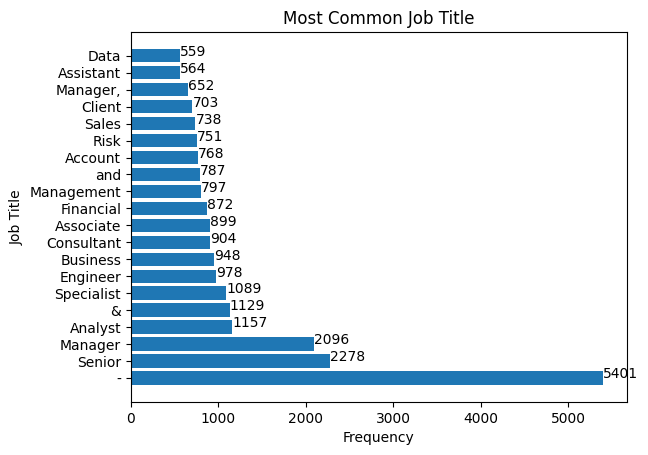

In [240]:

# plot horizontal bar for the most common job title words (other chart type)
import matplotlib.pyplot as plt
import pandas as pd


# Combine all job titles into one long string, split into individual words,
# and convert to a pandas Series to count them
words = pd.Series(' '.join(df_flat["title"]).split())
top = words.value_counts().head(20)   # Count how many times each word appears, then take the top 20 most common ones

fig, ax = plt.subplots()   # Create plot
ax.barh(top.index, top.values)  # Plot a horizontal bar chart of the top 20 words

ax.set_ylabel("Job Title")  # Label the y-axis
ax.set_xlabel("Frequency")   # Label the x-axis
ax.set_title("Most Common Job Title")  # Give the chart a title

for index, value in enumerate(top.values):   # Add numbers to bars
    ax.text(value, index, str(value))

plt.show()

Salary Stats Table (Formatted):
                      minSalary    maxSalary
workArrangementType                         
Remote               $68,168.79  $107,711.55
In-Office            $48,004.06   $74,951.39
Hybrid               $39,144.59   $60,155.99
Flexible             $21,229.39   $37,824.65
Temporarily Remote   $11,666.67   $14,000.00


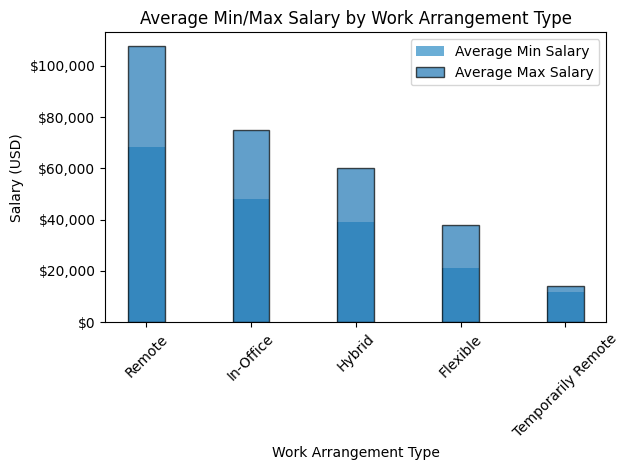

In [241]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert salary columns to numeric
df_flat["minSalary"] = pd.to_numeric(df_flat["minSalary"], errors="coerce")
df_flat["maxSalary"] = pd.to_numeric(df_flat["maxSalary"], errors="coerce")

# Keep only rows with salary + work arrangement
df_salary = df_flat[
    df_flat["minSalary"].notna() &
    df_flat["maxSalary"].notna() &
    df_flat["workArrangementType"].notna()
]

# Group and compute average salaries (numeric)
numeric_stats = (
    df_salary.groupby("workArrangementType")[["minSalary", "maxSalary"]]
             .mean()
             .sort_values("maxSalary", ascending=False)
)

# Save numeric values for plotting
min_vals = numeric_stats["minSalary"]
max_vals = numeric_stats["maxSalary"]

# Create a formatted copy for display
salary_stats = numeric_stats.copy()
salary_stats["minSalary"] = salary_stats["minSalary"].apply(lambda x: f"${x:,.2f}")
salary_stats["maxSalary"] = salary_stats["maxSalary"].apply(lambda x: f"${x:,.2f}")

print("Salary Stats Table (Formatted):")
print(salary_stats)

# Plot
plt.figure()

x = numeric_stats.index

plt.bar(x, min_vals, width=0.35, label="Average Min Salary", color="#6baed6")
plt.bar(x, max_vals, width=0.35, label="Average Max Salary", alpha=0.7, edgecolor="black")

plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, pos: f"${x:,.0f}")
)

plt.title("Average Min/Max Salary by Work Arrangement Type")
plt.ylabel("Salary (USD)")
plt.xlabel("Work Arrangement Type")
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

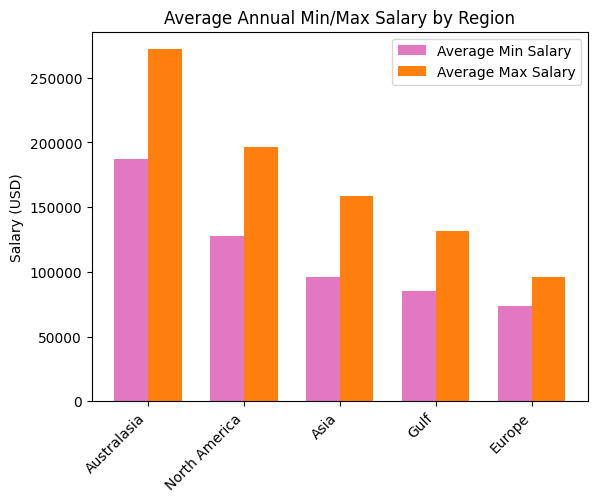

In [242]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

                            #build smaller dataset with just region + salaries
sal = df_flat[["region", "minSalary", "maxSalary"]].copy()

                 #clean salary columns (
for col in ["minSalary", "maxSalary"]:
    sal[col] = pd.to_numeric(sal[col], errors="coerce")
    sal.loc[sal[col] == 0, col] = np.nan   # remove zeros

                #compute the average salaries per region
region_avg = (
    sal.dropna(subset=["region", "maxSalary"])
       .groupby("region")[["minSalary", "maxSalary"]]
       .mean()
       .sort_values("maxSalary", ascending=False)
)

                   #extract into lists ( like the fruit example)
regions     = region_avg.index.tolist()
min_values  = region_avg["minSalary"].tolist()
max_values  = region_avg["maxSalary"].tolist()


                  #plot using the same style (fruit template reference) this is where the graph actually comes in
fig, ax = plt.subplots()
x = np.arange(len(regions))   #positions for the bars
width = 0.35

                       # for min and max salary x- width/2 allows me to shift min to the left
bars_min = ax.bar(x - width/2, min_values, width, label='Average Min Salary', color='tab:pink')
bars_max = ax.bar(x + width/2, max_values, width, label='Average Max Salary', color='tab:orange')
                                    #two bars per region

                        # label+title (referencing template from starter code)
ax.set_ylabel("Salary (USD)")
ax.set_title("Average Annual Min/Max Salary by Region")
ax.set_xticks(x)
ax.set_xticklabels(regions, rotation=45, ha="right")         #ha=horizontal alignment. prevents region from overlapping
ax.legend()


plt.show()

## Discussion and Results

Insights:

*  Based on the bar charts in the Model Building/Analysis section, we can see that this source of job listings has the most listings in North America, with Europe and Asia following second.

*  In the second bar chart, as hypothesized, a majority of jobs are listed as "hybrid." In-office positions followed, with flexible arrangements being more in demand than remote ones. It is important to note that some job listings did not provide information on the work arrangement type. From the 2,800 job listings that did display this information, hybrid arrangements are in higher demand, with remote careers having the least demand in this dataset. It has been half a decade since the pandemic, and it could be argued that companies are looking to have their employees back on site. There is room for further research here.

*   Across industries, it seems that demand for unpaid positions is slightly higher than that of paid positions.

*   The results show that Chubb is the most active recruiter at the top of the list. The insurance (Chubb) and financial services (Deutsche Bank and Marsh & McLennan) industries are the main providers of employment opportunities in this dataset, with fintech (Circle) emerging as a high-growth industry.

*  The results show that the most common job title is "-" which suggests a wide range of professions and responsibilities. According to the job title analysis, businesses are mostly looking for experienced employees who can occupy senior-level, management, and analytical roles, frequently involving multitasking duties.

*  Remote jobs offer the highest pay, ranging from 68,168 to 107,711. In-office and hybrid positions pay moderately, between 39,144 and 74,951. Flexible roles earn less, about 21,229 to 37,824, and temporarily remote jobs pay the least, around 11,667 to 14,000.













## Conclusion

Looking at this global job postings dataset gives us a good sense of how the labor market has changed since the pandemic. North America still leads in job opportunities, followed by Europe and Asia. Hybrid work has become the most common arrangement, showing how workplace culture has shifted, while fully remote roles are still less common.

Industries such as insurance, financial services, and fintech are driving hiring activity, with companies like Chubb, Deutsche Bank, and Marsh & McLennan leading recruitment efforts.Employers are generally looking for experienced candidates in senior, management, or analytical roles, often with multitasking responsibilities.

When it comes to pay, remote jobs offer the highest salaries, in-office and hybrid roles pay moderately, and flexible or temporarily remote positions earn the least. Overall, the data highlights how workforce demands, work arrangements, and high-growth sectors are evolving in today’s post-pandemic job market.

## References

1. Barber, David. Bayesian Reasoning and Machine Learning. Cambridge University Press, 2012.
2. Aste, Tomaso, Paola Cerchiello, and Roberta Scaramozzino. "Information-Theoretic Causality Detection between Financial and Sentiment Data."Entropy, vol. 24, no. 6, 2022, pp. 1–18. DOI:10.3390/e24060774.
3. Metz, Cade. "Microsoft Puts OpenAI’s Sam Altman in Charge of New Advanced AI Research Team."
The New York Times, 20 Nov. 2023, www.nytimes.com/2023/11/20/technology/openai-microsoft-altman.html
4. Bar color demo — Matplotlib 3.6.0 documentation. (n.d.). Matplotlib.org. https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_colors.html#sphx-glr-gallery-lines-bars-and-markers-bar-colors-py
5. GeeksforGeeks. (2021, March 25). Adding value labels on a Matplotlib Bar Chart. GeeksforGeeks. https://www.geeksforgeeks.org/python/adding-value-labels-on-a-matplotlib-bar-chart/
6. pandas.notna — pandas 2.3.3 documentation. (2017). Pydata.org. https://pandas.pydata.org/docs/reference/api/pandas.notna.html
7. The AI & DS Channel. (2022, September 23). How to display values on Bar Chart Python. YouTube. https://www.youtube.com/watch?v=orQWVU4Wbkw
7. The AI & DS Channel. (2022, September 23). How to display values on Bar Chart Python. YouTube. https://www.youtube.com/watch?v=orQWVU4Wbkw
8. McKinney, W. (2018). Python for Data Analysis: Data wrangling with pandas, NumPy, and ipython. O’Reilly Media, Inc.
9. Python for everybody - interactive — python for everybody - interactive. (n.d.). https://runestone.academy/ns/books/published/py4e-int/index.html

## Appendix